<a href="https://www.kaggle.com/code/yutakatarokusumah/osn-informatics-2025-semifinal-score-prediction?scriptVersionId=269118283" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This is OSN 2025 Semifinal Prediction I (Yutaka Taro Kusumah) made using ChatPGT.
This uses MLE (Maximum likelihod estimation) to estimate the parameters of normal distribution (mainly mean and spread).
What MLE does:
1. Start with a guess of mean and spread.
2. Check how likely it is to see the tail data you actually have, given that guess
3. If the guess puts underestimates the probability of getting the tail data, parameters gets down-weighted.
4. Search for the parameters μ (mean), σ (spread) that matches the observed tail the best.

Assumptions:
- Beta distribution. Normal distribution extend to −∞ and +∞, which means they will always "pretend" there's some probability mass outside the vlaid range. Beta distribution is natively bounded on \[0, 1\] and can be rescaled into \[0, MaxScore\]. It is flexible, as it can be made symmetric, skewed, U-shaped, flat, or bell-like.
- Right-tail data. Only the top-scorers of 46 Kokocoder contestant submit their score. So it is assumed that the mean/spread of the data lies much lower.
- No mean difference in scores for Kokocoders and non-Kokocoders.

### Imports

In [1]:
import numpy as np, math, pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize

If you want to update OSN scores (maybe results from previous years or a more updated version), do it here. 

In [2]:
# ---------------- EDIT IF YOU WANT PREDICT USING OSN DIFFERENT YEAR ----------------
scores_real = np.array([ # 2024 OSN Final
    600,567,537,456,443,420,419,419,415,414,406,402,397,364,345,343,
    331,331,319,317,313,308,295,277,276,271,262,253,243,241,231,225,
    224,219,218,217,215,207,205,203,202,198,198,194,191,181,180,177,
    171,167,159,157,154,152,146,139,138,136,135,133,125,111,109,108,
    107,101,99,98,97,97,86,84,81,75,67,66,65,51,48,46,46,43,41,24,
    24,24,24,23,18,18,13,13,13,13,13,10,10,0,0,0
], dtype=float)

MAX_SCORE_REAL = 600.0
# --- don't forget to change MAX_SCORE_REAL if you use OSN results from different year ---



# --------------------- EDIT WITH UPDATED VALUES FROM KOKOCODER ---------------------
scores_2025_tail = [ # Updated
    300,293,300,274,274,272,272,271,271,271,271,267,261,261,260,
    257,256,256,251,242,240,234,234,229,229,218,218,216,216,213,
    202
] # Outliers: 154,147,125,125,71

# scores_2025_tail = [ # Old
#     300,272,272,271,271,271,268,267,262,261,261,256,256,250,242,
#     240,234,230,229,224,216,212,202,202
# ]

N_COHORT   = 46            # NUmber of Kokocoder OSN (semi) finalists
MAX_SCORE_PRED  = 300           # 2025 max score
N_TARGET   = 100           # Number of OSN finalists
# -----------------------------------------------

### Normal Fit

To show you that (truncated) normal distribution is not feasible, here is the histogram with normal distribution fit of 2024 OSN Informatika score.

2024 mean = 185.47, std = 143.23, N=100
Actual 2024 cutoffs:
  Top 60 cutoff = 133.0
  Top 30 cutoff = 241.0
  Top 15 cutoff = 345.0


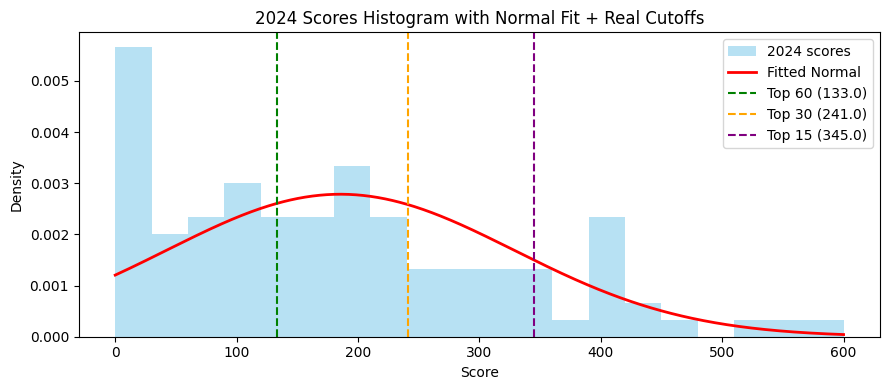

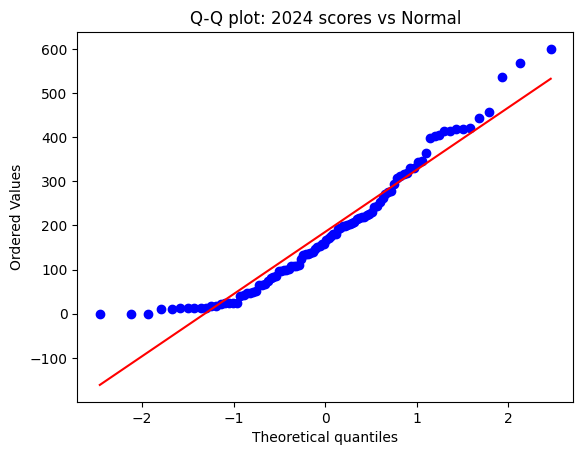

Shapiro–Wilk test: statistic=0.935, p=9.09e-05


In [3]:
# === Check Normality + Real Cutoffs for 2024 Scores ===

scores = scores_real
N_total = len(scores)
mu, sigma = np.mean(scores), np.std(scores, ddof=1)
print(f"2024 mean = {mu:.2f}, std = {sigma:.2f}, N={N_total}")

# --- Real cutoffs ---
sorted_scores = np.sort(scores)[::-1]  # descending
cut_real_60 = sorted_scores[59]   # index 59 = 60th highest
cut_real_30 = sorted_scores[29]   # index 29 = 30th highest
cut_real_15 = sorted_scores[14]   # index 14 = 15th highest

print(f"Actual 2024 cutoffs:")
print(f"  Top 60 cutoff = {cut_real_60}")
print(f"  Top 30 cutoff = {cut_real_30}")
print(f"  Top 15 cutoff = {cut_real_15}")

# --- Histogram + fitted Normal ---
plt.figure(figsize=(9,4))
plt.hist(scores, bins=20, density=True, alpha=0.6, color="skyblue", label="2024 scores")
xs = np.linspace(min(scores), max(scores), 500)
pdf = stats.norm.pdf(xs, mu, sigma)
plt.plot(xs, pdf, "r-", lw=2, label="Fitted Normal")
plt.axvline(cut_real_60, color="g", ls="--", label=f"Top 60 ({cut_real_60})")
plt.axvline(cut_real_30, color="orange", ls="--", label=f"Top 30 ({cut_real_30})")
plt.axvline(cut_real_15, color="purple", ls="--", label=f"Top 15 ({cut_real_15})")
plt.title("2024 Scores Histogram with Normal Fit + Real Cutoffs")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- Q-Q plot ---
stats.probplot(scores, dist="norm", plot=plt)
plt.title("Q-Q plot: 2024 scores vs Normal")
plt.show()

# --- Normality tests ---
shapiro_stat, shapiro_p = stats.shapiro(scores)
ks_stat, ks_p = stats.kstest((scores - mu) / sigma, "norm")

print(f"Shapiro–Wilk test: statistic={shapiro_stat:.3f}, p={shapiro_p:.3g}")

A quick look at the histogram evidently shows that normal distribution is not a great fit. Q-Q plot does not lie well on the identity line, and Shapiro-Wilk test with p < 0.05 means significant evidence shows that data is not normally distributed.

Then, using normal distribution means that we ASSUME the data is symmetrical, i.e., the amount of people who fail hard (scores 0) is the same as the amount of people who got near-perfect scores. So, the prediction will overestimates the cut-off for the top 60 people who will advance into OSN Informatika. Shown below:

Fitted truncated Normal on [0,300]: mu=250.00, sigma=69.82
Cutoffs for N=100:
  Top 60 -> 214.45
  Top 30 -> 255.99
  Top 15 -> 276.64


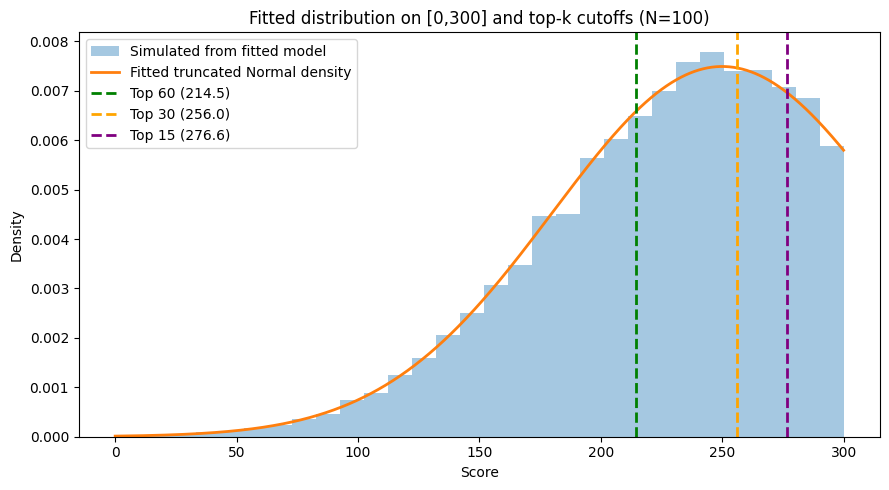

In [4]:
# === OSN/Contest Score Modeling: Truncated-Normal (Censored MLE) ===

scores_tail = scores_2025_tail
scores_tail = np.array(scores_tail, dtype=float)
LOW, HIGH = 0.0, float(MAX_SCORE_PRED)
m = len(scores_tail)
x0 = float(np.min(scores_tail))          # cutoff inferred from your tail
n_below = N_COHORT - m                        # censored count below cutoff

# --- Standard normal utilities (no scipy needed) ---
def std_normal_cdf(z):
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

# --- Truncated Normal on [LOW, HIGH] utilities ---
def log_pdf_trunc(x, mu, sigma):
    if sigma <= 0:
        return -np.inf
    a = (LOW  - mu) / sigma
    b = (HIGH - mu) / sigma
    Z = std_normal_cdf(b) - std_normal_cdf(a)
    if Z <= 0:
        return -np.inf
    z = (x - mu) / sigma
    return -0.5*z*z - math.log(sigma) - 0.5*math.log(2*math.pi) - math.log(Z)

def tail_mass(mu, sigma, cutoff):
    # S = P(X >= cutoff | LOW <= X <= HIGH) under Normal(mu,sigma)
    if sigma <= 0:
        return 0.0
    a = (LOW    - mu) / sigma
    c = (cutoff - mu) / sigma
    b = (HIGH   - mu) / sigma
    Z = std_normal_cdf(b) - std_normal_cdf(a)
    if Z <= 0:
        return 0.0
    return (std_normal_cdf(b) - std_normal_cdf(c)) / Z

def loglik_censored(mu, sigma, x_tail, cutoff, N_total):
    # Exact tail values + censored count below cutoff
    if sigma <= 0:
        return -np.inf
    S = tail_mass(mu, sigma, cutoff)
    if S <= 0 or S >= 1:
        return -np.inf
    ll = 0.0
    for x in x_tail:
        v = log_pdf_trunc(float(x), mu, sigma)
        if not np.isfinite(v):
            return -np.inf
        ll += v
    m = len(x_tail)
    n_below = N_total - m
    ll += n_below * math.log(1.0 - S)
    return ll

# --- Fit (mu, sigma) by coarse grid search (fast, no optimizer needed) ---
def fit_truncnorm_censored(x_tail, cutoff, N_total):
    # heuristic grids; widen/narrow if needed
    mu_grid    = np.linspace(50, HIGH-50, 201)     # e.g., 50..250 for MAX=300
    sigma_grid = np.linspace(10, HIGH/2, 111)      # e.g., 10..150
    best = (-np.inf, None, None)
    for mu in mu_grid:
        for sigma in sigma_grid:
            ll = loglik_censored(mu, sigma, x_tail, cutoff, N_total)
            if ll > best[0]:
                best = (ll, mu, sigma)
    return best  # (best_ll, mu_hat, sigma_hat)

best_ll, mu_hat, sigma_hat = fit_truncnorm_censored(scores_tail, x0, N_COHORT)

# --- Truncated CDF and quantile ---
def cdf_trunc(x, mu, sigma):
    a = (LOW  - mu) / sigma
    b = (HIGH - mu) / sigma
    Z = std_normal_cdf(b) - std_normal_cdf(a)
    if Z <= 0:
        return 0.0
    return (std_normal_cdf((x - mu)/sigma) - std_normal_cdf(a)) / Z

def quantile_trunc(p, mu, sigma, iters=60):
    lo, hi = LOW, HIGH
    for _ in range(iters):
        mid = 0.5*(lo+hi)
        if cdf_trunc(mid, mu, sigma) < p:
            lo = mid
        else:
            hi = mid
    return 0.5*(lo+hi)

# --- Cutoff for top-k of N_TARGET (i.e., P(X >= t) = k/N_TARGET) ---
def cutoff_for_top_k(k, N_TARGET, mu, sigma):
    tail_prob = k / float(N_TARGET)
    p = 1.0 - tail_prob
    return quantile_trunc(p, mu, sigma)

# Compute requested cutoffs
cut_norm_60 = cutoff_for_top_k(60, N_TARGET, mu_hat, sigma_hat)
cut_norm_30 = cutoff_for_top_k(30, N_TARGET, mu_hat, sigma_hat)
cut_norm_15 = cutoff_for_top_k(15, N_TARGET, mu_hat, sigma_hat)

print(f"Fitted truncated Normal on [0,{int(HIGH)}]: mu={mu_hat:.2f}, sigma={sigma_hat:.2f}")
print(f"Cutoffs for N={N_TARGET}:")
print(f"  Top 60 -> {cut_norm_60:.2f}")
print(f"  Top 30 -> {cut_norm_30:.2f}")
print(f"  Top 15 -> {cut_norm_15:.2f}")

# --- Visualization: model density + simulated histogram + cutoff lines ---
# Simulate a larger sample to visualize distribution shape
rng = np.random.default_rng(42)
def sample_truncnorm(mu, sigma, size):
    out = []
    need = size
    # simple rejection sampler
    while len(out) < size:
        draws = rng.normal(mu, sigma, int(1.5*need) + 1000)
        draws = draws[(draws >= LOW) & (draws <= HIGH)]
        out.extend(draws.tolist())
        need = size - len(out)
    return np.array(out[:size])

sim = sample_truncnorm(mu_hat, sigma_hat, 20000)

# Plot
xs = np.linspace(LOW, HIGH, 1001)
# density up to normalization constant of truncated normal
a = (LOW  - mu_hat) / sigma_hat
b = (HIGH - mu_hat) / sigma_hat
Z = std_normal_cdf(b) - std_normal_cdf(a)
pdf = (1.0/(sigma_hat*np.sqrt(2*np.pi))) * np.exp(-0.5*((xs - mu_hat)/sigma_hat)**2) / Z

plt.figure(figsize=(9,5))
plt.hist(sim, bins=30, density=True, alpha=0.4, label="Simulated from fitted model")
plt.plot(xs, pdf, linewidth=2, label="Fitted truncated Normal density")
plt.axvline(cut_norm_60, linestyle="--", linewidth=2, color="g", label=f"Top 60 ({cut_norm_60:.1f})")
plt.axvline(cut_norm_30, linestyle="--", linewidth=2, color="orange", label=f"Top 30 ({cut_norm_30:.1f})")
plt.axvline(cut_norm_15, linestyle="--", linewidth=2, color="purple", label=f"Top 15 ({cut_norm_15:.1f})")
plt.title(f"Fitted distribution on [0,{int(HIGH)}] and top-k cutoffs (N={N_TARGET})")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

### Beta Fit

Fitted Beta params: alpha=0.556, beta=1.135  (loc=0, scale=1)


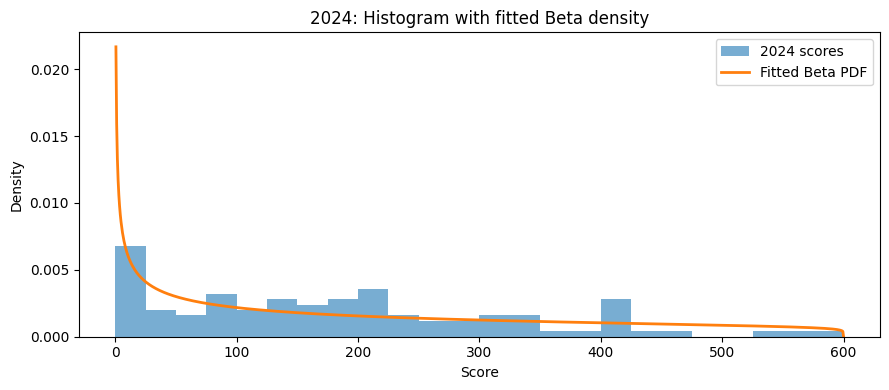

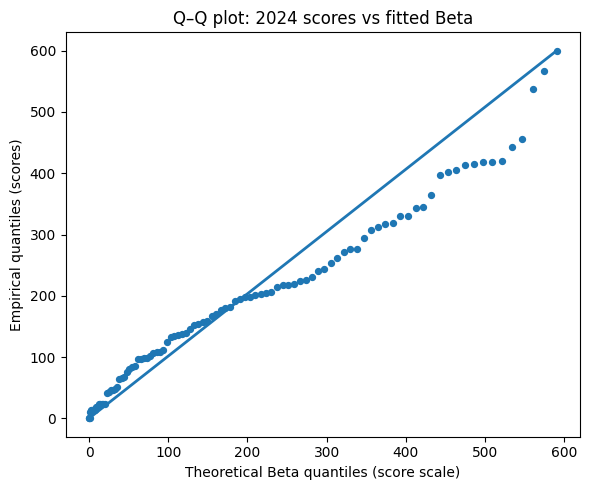

KS test vs fitted Beta (on [0,1]): statistic=0.097, p=0.284
n=100, mean=185.47, std=143.23, min=0.0, p50=163.0, max=600.0


In [5]:
# === Beta fit & diagnostics for 2024 scores (bounded [0,600]) ===

scores = scores_real
n = scores.size
# 1) Rescale to [0,1] and ε-clip to avoid exact 0/1 at the boundaries for MLE
# уυтαкα тαяσ кυѕυмαн
eps = 1e-6
z = np.clip(scores / MAX_SCORE_REAL, eps, 1.0 - eps)

# 2) Fit Beta(α,β) by MLE on z
#    Force support to be exactly [0,1] via floc=0, fscale=1
a_hat, b_hat, loc_hat, scale_hat = stats.beta.fit(z, floc=0, fscale=1)
print(f"Fitted Beta params: alpha={a_hat:.3f}, beta={b_hat:.3f}  (loc={loc_hat}, scale={scale_hat})")

# 3) Histogram + fitted Beta PDF on original score scale [0,600]
#    To overlay correctly: f_score(x) = (1/MAX) * beta.pdf(x/MAX; a,b)
xs = np.linspace(0.0, MAX_SCORE_REAL, 1001)
pdf_scores = stats.beta.pdf(xs / MAX_SCORE_REAL, a_hat, b_hat) / MAX_SCORE_REAL

plt.figure(figsize=(9,4))
plt.hist(scores, bins=24, density=True, alpha=0.6, label="2024 scores")
plt.plot(xs, pdf_scores, linewidth=2, label="Fitted Beta PDF")
plt.title("2024: Histogram with fitted Beta density")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Q–Q plot vs Beta on score scale
#    Theoretical quantiles from fitted Beta, mapped back to [0,600]
u = (np.arange(1, n+1) - 0.5) / n
theory_q = stats.beta.ppf(u, a_hat, b_hat) * MAX_SCORE_REAL
emp_q = np.sort(scores)

plt.figure(figsize=(6,5))
plt.scatter(theory_q, emp_q, s=18)
# reference line through (min-min, max-max)
x0, x1 = theory_q[0], theory_q[-1]
y0, y1 = emp_q[0], emp_q[-1]
slope = (y1 - y0) / (x1 - x0) if x1 > x0 else 1.0
ref_x = np.linspace(x0, x1, 2)
plt.plot(ref_x, y0 + slope*(ref_x - x0), linewidth=2)
plt.title("Q–Q plot: 2024 scores vs fitted Beta")
plt.xlabel("Theoretical Beta quantiles (score scale)")
plt.ylabel("Empirical quantiles (scores)")
plt.tight_layout()
plt.show()

# 5) KS test against fitted Beta (on [0,1] scale)
ks_stat, ks_p = stats.kstest(z, 'beta', args=(a_hat, b_hat))
print(f"KS test vs fitted Beta (on [0,1]): statistic={ks_stat:.3f}, p={ks_p:.3g}")

# Optional: quick summary
print(f"n={n}, mean={scores.mean():.2f}, std={scores.std(ddof=1):.2f}, "
      f"min={scores.min():.1f}, p50={np.median(scores):.1f}, max={scores.max():.1f}")


Beta distribution makes more sense, as research into past OSN Informatika scores shows that a lot of people (5-10) have 0 score, with more having a very low score. Q-Q plot fits nicely into identity line, confirming the use of beta distribution.

Now, using MLE with beta prediction:

Fitted Beta params (2025): alpha=1.612, beta=0.630
P(X >= 202) under fitted Beta = 0.638  (observed ~ 0.674)

Predicted 2025 cutoffs (scores and % of 300):
  Top 60: 212.44  (70.8%)
  Top 30: 273.18  (91.1%)
  Top 15: 291.27  (97.1%)


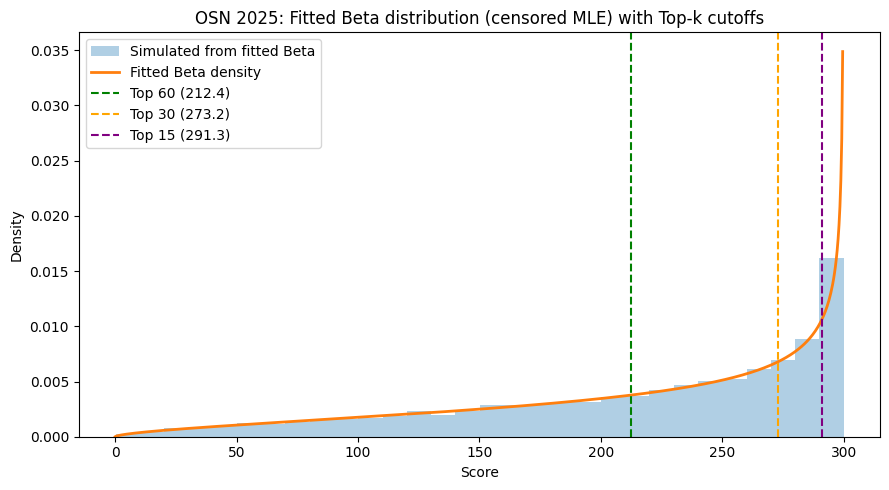

In [6]:
# === OSN 2025: Beta fit with censored MLE (bounded [0,300]) ===

scores_tail = scores_2025_tail
scores_tail = np.asarray(scores_tail, dtype=float)
LOW, HIGH = 0.0, MAX_SCORE_PRED
# ---------------- Prep ----------------
m = len(scores_tail)
n_below = N_COHORT - m
cutoff_score = float(np.min(scores_tail))           # 202
z_tail = scores_tail / MAX_SCORE_PRED                    # rescale to [0,1]
eps = 1e-6
# only fix exact boundaries to avoid log(0)/inf in MLE
z_tail[z_tail <= 0.0] = eps
z_tail[z_tail >= 1.0] = 1.0 - eps
cutoff = cutoff_score / MAX_SCORE_PRED                        # 202/300

# ---------------- Censored MLE for Beta(α,β) ----------------
# Log-likelihood = sum log pdf for tail scores  +  (n_below)*log( P(X<cutoff) )
# Easter egg: Made by Y-u-t-a-k-a
def neg_loglik(params):
    alpha, beta = params
    if alpha <= 0 or beta <= 0:
        return 1e12
    ll_tail = np.sum(stats.beta.logpdf(z_tail, alpha, beta))
    S = 1.0 - stats.beta.cdf(cutoff, alpha, beta)  # P(Z >= cutoff)
    if not np.isfinite(S) or S <= 0 or S >= 1:
        return 1e12
    ll_cens = n_below * math.log(1.0 - S)          # mass below cutoff
    return -(ll_tail + ll_cens)

res = optimize.minimize(
    neg_loglik, x0=[2.0, 5.0], bounds=[(0.2, 100), (0.2, 100)],
    method="L-BFGS-B"
)
alpha_hat, beta_hat = map(float, res.x)
print(f"Fitted Beta params (2025): alpha={alpha_hat:.3f}, beta={beta_hat:.3f}")

# Sanity check: does the model match the observed tail fraction 24/46?
p_ge_202 = 1.0 - stats.beta.cdf(cutoff, alpha_hat, beta_hat)
print(f"P(X >= 202) under fitted Beta = {p_ge_202:.3f}  (observed ~ {m/N_COHORT:.3f})")

# ---------------- Top-k cutoffs (N_TARGET = 100) ----------------
def cutoff_for_top_k(k, N_TARGET=100):
    # solve P(X >= t_k) = k / N_TARGET  => t_k = Beta.ppf(1 - k/N_TARGET)
    q = stats.beta.ppf(1.0 - k / N_TARGET, alpha_hat, beta_hat)
    return float(q * MAX_SCORE_PRED)

cut_beta_60 = cutoff_for_top_k(60, N_TARGET)
cut_beta_30 = cutoff_for_top_k(30, N_TARGET)
cut_beta_15 = cutoff_for_top_k(15, N_TARGET)

print("\nPredicted 2025 cutoffs (scores and % of 300):")
print(f"  Top 60: {cut_beta_60:.2f}  ({cut_beta_60/MAX_SCORE_PRED*100:.1f}%)")
print(f"  Top 30: {cut_beta_30:.2f}  ({cut_beta_30/MAX_SCORE_PRED*100:.1f}%)")
print(f"  Top 15: {cut_beta_15:.2f}  ({cut_beta_15/MAX_SCORE_PRED*100:.1f}%)")

# ---------------- Plot: fitted density and cutoffs ----------------
xs = np.linspace(0.0, MAX_SCORE_PRED, 800)
pdf = stats.beta.pdf(xs / MAX_SCORE_PRED, alpha_hat, beta_hat) / MAX_SCORE_PRED

plt.figure(figsize=(9,5))
# simulated histogram (optional, just to visualize a shape consistent with model)
rng = np.random.default_rng(42)
sim = stats.beta.rvs(alpha_hat, beta_hat, size=20000, random_state=rng) * MAX_SCORE_PRED
plt.hist(sim, bins=30, density=True, alpha=0.35, label="Simulated from fitted Beta")

plt.plot(xs, pdf, lw=2, label="Fitted Beta density")
plt.axvline(cut_beta_60, ls="--", color="g", label=f"Top 60 ({cut_beta_60:.1f})")
plt.axvline(cut_beta_30, ls="--", color="orange", label=f"Top 30 ({cut_beta_30:.1f})")
plt.axvline(cut_beta_15, ls="--", color="purple", label=f"Top 15 ({cut_beta_15:.1f})")
plt.title("OSN 2025: Fitted Beta distribution (censored MLE) with Top-k cutoffs")
plt.xlabel("Score"); plt.ylabel("Density"); plt.legend(); plt.tight_layout(); plt.show()

As there is a lot of people getting 200+, prediction shows that the amount of contestants that got 0 is not as much as 2024 OSN finalist.

In [7]:
# ---- Assemble comparison tables (separate raw and %) ----
rows_score = []
rows_pct = []

def pct(x, maxv): return 100.0 * x / maxv

rows_score.append({
    "Cutoff": "Top 60",
    "2024 Actual": cut_real_60,
    "2025 Beta MLE": cut_beta_60,
    "2025 Normal MLE": cut_norm_60,
})
rows_pct.append({
    "Cutoff": "Top 60",
    "2024 Actual (%)": pct(cut_real_60, MAX_SCORE_REAL),
    "2025 Beta MLE (%)": pct(cut_beta_60, MAX_SCORE_PRED),
    "2025 Normal MLE (%)": pct(cut_norm_60, MAX_SCORE_PRED),
})

rows_score.append({
    "Cutoff": "Top 30",
    "2024 Actual": cut_real_30,
    "2025 Beta MLE": cut_beta_30,
    "2025 Normal MLE": cut_norm_30,
})
rows_pct.append({
    "Cutoff": "Top 30",
    "2024 Actual (%)": pct(cut_real_30, MAX_SCORE_REAL),
    "2025 Beta MLE (%)": pct(cut_beta_30, MAX_SCORE_PRED),
    "2025 Normal MLE (%)": pct(cut_norm_30, MAX_SCORE_PRED),
})

rows_score.append({
    "Cutoff": "Top 15",
    "2024 Actual": cut_real_15,
    "2025 Beta MLE": cut_beta_15,
    "2025 Normal MLE": cut_norm_15,
})
rows_pct.append({
    "Cutoff": "Top 15",
    "2024 Actual (%)": pct(cut_real_15, MAX_SCORE_REAL),
    "2025 Beta MLE (%)": pct(cut_beta_15, MAX_SCORE_PRED),
    "2025 Normal MLE (%)": pct(cut_norm_15, MAX_SCORE_PRED),
})

# Build DataFrames
df_scores = pd.DataFrame(rows_score)
df_pct = pd.DataFrame(rows_pct)

# Round for clean display
df_scores_display = df_scores.copy()
df_pct_display = df_pct.copy()
for col in df_scores_display.columns:
    if col != "Cutoff":
        df_scores_display[col] = df_scores_display[col].astype(float).round(2)
for col in df_pct_display.columns:
    if col != "Cutoff":
        df_pct_display[col] = df_pct_display[col].astype(float).round(2)

# Show both tables
print("Cutoff comparison (raw scores):")
display(df_scores_display)

print("\nCutoff comparison (how much % of max score do you need to get into top-X):")
display(df_pct_display)

Cutoff comparison (raw scores):


,Cutoff,2024 Actual,2025 Beta MLE,2025 Normal MLE
0,Top 60,133.0,212.44,214.45
1,Top 30,241.0,273.18,255.99
2,Top 15,345.0,291.27,276.64



Cutoff comparison (how much % of max score do you need to get into top-X):


,Cutoff,2024 Actual (%),2025 Beta MLE (%),2025 Normal MLE (%)
0,Top 60,22.17,70.81,71.48
1,Top 30,40.17,91.06,85.33
2,Top 15,57.50,97.09,92.21


In [8]:
# check tail calibration
p_ge_200 = 1 - stats.beta.cdf(200/300, alpha_hat, beta_hat)
print("P(X>=200) under your Beta =", p_ge_200, "  (should make sense, like around 0.50)")

# check top-15 cutoff vs 202
t15 = stats.beta.ppf(0.85, alpha_hat, beta_hat) * 300
print("Top-15 cutoff =", t15, "  (should realistically be >= 200)")



P(X>=200) under your Beta = 0.6448780414591236   (should make sense, like around 0.50)
Top-15 cutoff = 291.27389607229975   (should realistically be >= 200)


MLE using both Beta and Normal distribution shows similar prediction results, but is wildly different from 2024 actual cutoff. On the first glance, this might suggests the prediction is inaccurate, but further checking into P(X>=202) and top-15 cutoff clearly aligns with the prediction data. Hence, it can be inferred that 2025 OSN Semifinal is much easier than 2024 OSN Final Informatika.
Using the current most updated data (13/09/2025 12:36), the predicted (using Beta MLE) cut-off values to get into OSN 2025 Finalist is....
## 212.44
(Note: Running a mixture beta distribution (combining two beta distributions) yield similar results, with **216.16** for top-60, 254.11 for top-30, and 273.85 for top-15).

(ADDITIONAL) We can use ChatGPT magic to calculate the probability of getting into the top-60 given your score, X.

In [9]:
your_score = 180


# ---------- Continuous (no ties) analytic probability ----------
y = your_score / MAX_SCORE_PRED
p_ge = 1.0 - stats.beta.cdf(y, alpha_hat, beta_hat)   # Pr(opponent >= your score)
M = int(N_TARGET - 1)                                 # number of opponents

# top-60 means at most 59 opponents >= you
p_top60_cont = stats.binom.cdf(59, M, p_ge)

print("Continuous (no ties) model:")
print(f"  p_ge = Pr(opponent >= {your_score}) = {p_ge:.6f}")
print(f"  P(top-60 | {your_score}) = binom.cdf(59, {M}, p_ge) = {p_top60_cont:.6g}")

# ---------- Discrete / tie-aware exact probability (optional) ----------
# This calculates probability if scores are integers 0..MAX_SCORE_PRED,
# by mapping integer s to a bin [s-0.5, s+0.5) in the scaled [0,1] space.
def tie_aware_prob_topk_intscore(s_int, K, N, a, b, Smax):
    lo = max(0.0, (s_int - 0.5) / Smax)
    hi = min(1.0, (s_int + 0.5) / Smax)
    F_lo = stats.beta.cdf(lo, a, b)
    F_hi = stats.beta.cdf(hi, a, b)

    p_eq = max(0.0, F_hi - F_lo)
    p_lt = F_lo
    p_gt = 1.0 - p_lt - p_eq
    # numerical safety
    p_lt = max(0.0, min(1.0, p_lt))
    p_gt = max(0.0, min(1.0, p_gt))
    ssum = p_lt + p_eq + p_gt
    p_lt, p_eq, p_gt = p_lt/ssum, p_eq/ssum, p_gt/ssum

    M = N - 1
    p_win = 0.0
    from scipy.special import gammaln
    for G in range(0, min(M, K)):
        KG = K - G
        maxE = M - G
        for E in range(0, maxE + 1):
            L = M - G - E
            # log multinomial
            log_mult = (gammaln(M+1) - (gammaln(G+1)+gammaln(E+1)+gammaln(L+1)))
            # log prob
            lp = log_mult
            if p_gt > 0: lp += G * math.log(p_gt)
            if p_eq > 0: lp += E * math.log(p_eq)
            if p_lt > 0: lp += L * math.log(p_lt)
            prob_GEL = math.exp(lp)
            # tie-win weight
            if KG >= E + 1:
                w = 1.0
            elif KG <= 0:
                w = 0.0
            else:
                w = KG / (E + 1.0)
            p_win += prob_GEL * w
    return float(p_win)

p_top60_tie = tie_aware_prob_topk_intscore(int(round(your_score)), 60, N_TARGET, alpha_hat, beta_hat, MAX_SCORE_PRED)
print("\nDiscrete/tie-aware model (integer bins):")
print(f"  P(top-60 | {your_score}) = {p_top60_tie:.6g}")

Continuous (no ties) model:
  p_ge = Pr(opponent >= 180) = 0.709626
  P(top-60 | 180) = binom.cdf(59, 99, p_ge) = 0.010094

Discrete/tie-aware model (integer bins):
  P(top-60 | 180) = 0.0101074


Update (19/10/2025):
The finalist result has been released around a month ago. Based on looking the scores of the people who passed the final round, the true cutoff is between 180 - 200.
Permission to use OSN semifinalist Kokocoders contestants has been granted by the founder of Kokocoder, Arnold Ardianto. Proof (WhatsApp chat in Indonesian language):
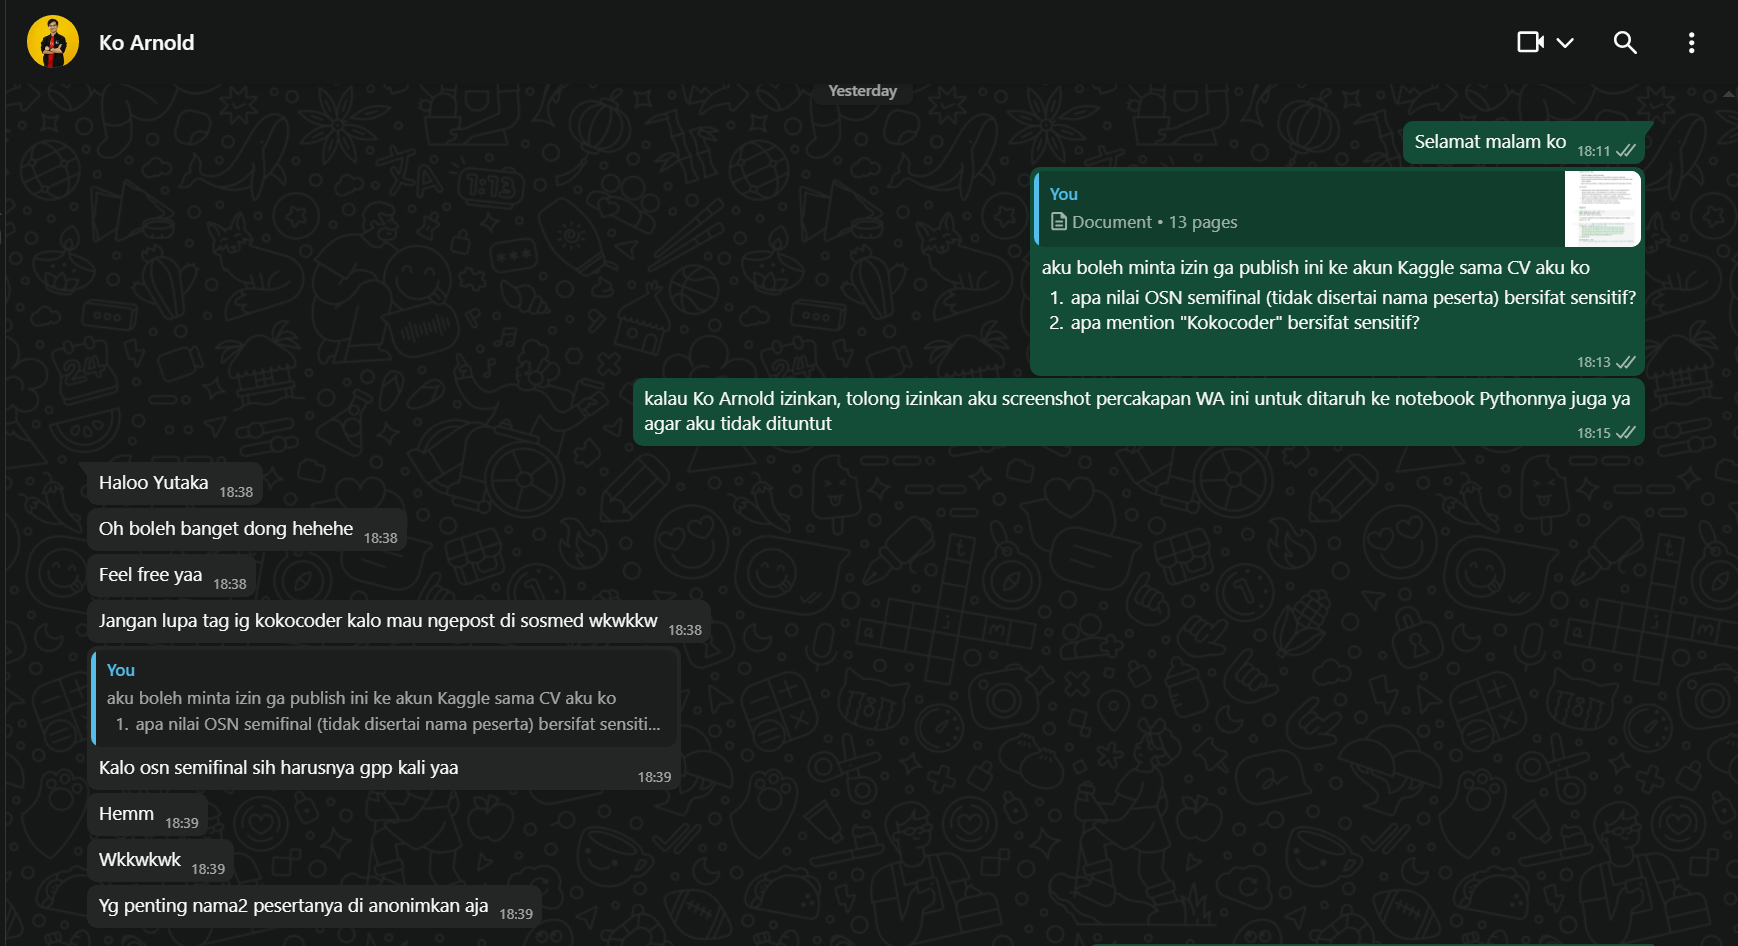
